# Wrangle Bluetooth Data

We wrangle the bluetooth data into a workable format, and extract the travel time between the sites we are interested in.

## Import data

In [1]:
import pandas as pd
f = pd.read_csv('../data/BLUETH_20150819.filtered.BT', header=None, names=['Site', 'Unix Time', 'Anonymized Bluetooth ID'])
f.head()

,Site,Unix Time,Anonymized Bluetooth ID
0,2409,1439942412,7D5561C29B78282F0AF56B411FABF392
1,2425,1439942415,135B591E6C16C88BA6CBB6CF5E0D445B
2,2409,1439942420,2469C4DB6C18C45FCF93B4ED49326231
3,2409,1439942434,9B2E7BB216C39A75608D0C162BA96296
4,2425,1439942434,DB7E50C1566C81CB7BC7E38E3268D5B7


## Sort and Group

Collect together vehicles based on their bluetooth ID. Sort by time.

In [2]:
f_sorted = f.sort_values(by=['Anonymized Bluetooth ID', 'Unix Time'])
f_sorted.head()

,Site,Unix Time,Anonymized Bluetooth ID
37710,2425,1439992916,0003EC7E6B7C10F03B1FD275C31C3091
37716,2425,1439992921,0003EC7E6B7C10F03B1FD275C31C3091
37737,2425,1439992941,0003EC7E6B7C10F03B1FD275C31C3091
41305,2425,1439995956,0003EC7E6B7C10F03B1FD275C31C3091
48182,2425,1440001697,0003EC7E6B7C10F03B1FD275C31C3091


In [3]:
f_groups = f_sorted.groupby(['Anonymized Bluetooth ID'])

In [4]:
# trace of vehicle with bluetooth id 000B18...
sample_veh = f_groups.get_group('000B1865B7FAA931B56B92C344F6B56B')
sample_veh

,Site,Unix Time,Anonymized Bluetooth ID
14984,2425,1439973653,000B1865B7FAA931B56B92C344F6B56B
14992,2425,1439973663,000B1865B7FAA931B56B92C344F6B56B
15016,2425,1439973687,000B1865B7FAA931B56B92C344F6B56B
15032,2425,1439973707,000B1865B7FAA931B56B92C344F6B56B
15045,2425,1439973725,000B1865B7FAA931B56B92C344F6B56B
15071,2425,1439973746,000B1865B7FAA931B56B92C344F6B56B
56527,2409,1440008826,000B1865B7FAA931B56B92C344F6B56B
57289,2425,1440009666,000B1865B7FAA931B56B92C344F6B56B
57317,2425,1440009693,000B1865B7FAA931B56B92C344F6B56B
57334,2425,1440009707,000B1865B7FAA931B56B92C344F6B56B


## Segments

Track travel time between sequentially visited sites

In [5]:
def segments(df):
    """
    Convert ordered table of visited sites into segments between adjacent nodes.
    dataframe -- site, time, bluetooth_id
    """
    results = []
    last_row = None
    for index, row in df.iterrows():
        if last_row is not None and row["Site"] != last_row["Site"]:
            segment = (last_row["Anonymized Bluetooth ID"],
                       last_row["Site"],
                       row["Site"],
                       last_row["Unix Time"],
                       row["Unix Time"])
            results.append(segment)
        last_row = row
    return results

segments(sample_veh)

[('000B1865B7FAA931B56B92C344F6B56B', 2425, 2409, 1439973746, 1440008826),
 ('000B1865B7FAA931B56B92C344F6B56B', 2409, 2425, 1440008826, 1440009666)]

In [6]:
results = []
for bt_id, data in f_groups:
    for segment in segments(data):
        results.append(segment)

all_segments = pd.DataFrame(results,
                            columns=('Anonymized Bluetooth ID', 'Site A', 'Site B', 'Time A', 'Time B'))

In [7]:
all_segments.head()

,Anonymized Bluetooth ID,Site A,Site B,Time A,Time B
0,000B1865B7FAA931B56B92C344F6B56B,2425,2409,1439973746,1440008826
1,000B1865B7FAA931B56B92C344F6B56B,2409,2425,1440008826,1440009666
2,001504BE590593C444A53BBF36BB5766,2425,2409,1439960640,1439994312
3,001504BE590593C444A53BBF36BB5766,2409,2425,1439994312,1439995055
4,00A8D3A8D3193707A47512E332A04B8E,2425,2409,1439993496,1439994212


# Filter Direction

Consider only outbound/westbound traffic originating from site 2409, traveling to site 2425

In [8]:
inbound = all_segments[all_segments["Site A"] == 2409]

In [9]:
inbound = inbound.copy()
inbound.head()

,Anonymized Bluetooth ID,Site A,Site B,Time A,Time B
1,000B1865B7FAA931B56B92C344F6B56B,2409,2425,1440008826,1440009666
3,001504BE590593C444A53BBF36BB5766,2409,2425,1439994312,1439995055
6,00AA2C5E7B0FC69467FCA798179BC41F,2409,2425,1439985342,1439986392
8,00AA2C5E7B0FC69467FCA798179BC41F,2409,2425,1440007983,1440009078
10,00E5C469BA14439C1591B02D64F9AE9E,2409,2425,1440000409,1440002050


# Cacluate Travel Time

In [10]:
travel_time = inbound["Time B"] - inbound["Time A"]
inbound["Travel Time"] = travel_time

In [11]:
inbound.head()

,Anonymized Bluetooth ID,Site A,Site B,Time A,Time B,Travel Time
1,000B1865B7FAA931B56B92C344F6B56B,2409,2425,1440008826,1440009666,840
3,001504BE590593C444A53BBF36BB5766,2409,2425,1439994312,1439995055,743
6,00AA2C5E7B0FC69467FCA798179BC41F,2409,2425,1439985342,1439986392,1050
8,00AA2C5E7B0FC69467FCA798179BC41F,2409,2425,1440007983,1440009078,1095
10,00E5C469BA14439C1591B02D64F9AE9E,2409,2425,1440000409,1440002050,1641


# Plot Vehicle Travel Times

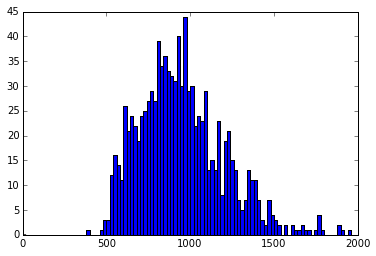

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

tt = list(travel_time)
bins = np.linspace(0, 2000, 101)
plt.hist(tt, bins=bins)
plt.show()

/home/asimmons/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


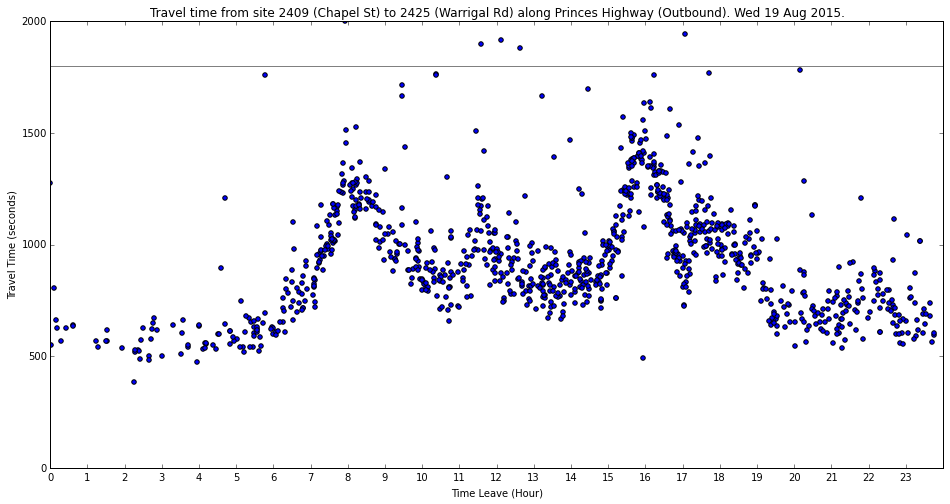

In [13]:
import calendar
plt.figure(figsize=(16,8))
start_of_day = calendar.timegm((2015,8,19,0,0,0))
plt.scatter(list((inbound["Time A"] - start_of_day)/3600), list(inbound["Travel Time"]))
plt.title("Travel time from site 2409 (Chapel St) to 2425 (Warrigal Rd) along Princes Highway (Outbound). Wed 19 Aug 2015.")
plt.ylabel("Travel Time (seconds)")
plt.xlabel("Time Leave (Hour)")
plt.xticks(np.arange(24))
plt.xlim([0,24])
plt.ylim([0,2000])
plt.axhline(y=1800, color='grey') # threshold
plt.show()

# Aggregate

Aggregate into 15 minute bins. Some vehicles stop along the way, take a longer route, or only pass the other site on the way back from their desitination. We eliminate these by only considering reasonable travel times, then taking the median value.

In [14]:
# Filter extreme travel times
inbound = inbound[inbound["Travel Time"] <= 1800]

In [15]:
max(inbound["Travel Time"])

1781

Experiment with timezones. Times *should* be stated as seconds since the Unix Epoch (00:00:00 UTC 1970), which would result in the start of the Australian day being 10:00:00 UTC. Since this is not the case, it seems that VicRoads has set their server clock to localtime rather than UTC. This is wrong, but convenient.

In [16]:
import datetime
start_of_day = min(inbound["Time A"])
print (start_of_day)
print (datetime.datetime.utcfromtimestamp(start_of_day))

1439942420
2015-08-19 00:00:20


In [17]:
import datetime

def parse_date(unix_time):
    d_utc = datetime.datetime.utcfromtimestamp(unix_time)
    # Unix servers *should* have their system clock set to UTC.
    # So we theoretically, we need to convert from UTC to AEST (localtime).
    # However, VicRoads seems to have set their operating system clock to AEST.
    # The easiest way to deal with this, is to treat all datetimes as naive (ignore timezone).
    # TLDR; VicRoads didn't handle timezones correctly. We need to copy their error for consistency.
    d_local = d_utc # Naive datetime. It's already shifted to AEST (but shouldn't be)
    return d_local

ts = pd.Series(list(inbound["Travel Time"]),
               index=list([parse_date(t) for t in inbound["Time A"]]))

In [18]:
ts.sort_index().tail()

2015-08-19 23:38:37    737
2015-08-19 23:39:07    679
2015-08-19 23:42:43    562
2015-08-19 23:44:46    596
2015-08-19 23:44:50    603
dtype: int64

In [19]:
ts_resampled = ts.resample('15Min', how='median')

# Index over entire day, even if some times are missing. Last 15 minutes usualy not present.
rng = pd.date_range('2015-08-19 00:00:00', periods=24*4, freq='15Min')
ts_resampled = pd.Series(ts_resampled, index=rng)

# Fill in missing values
ts_resampled = ts_resampled.fillna(method='pad')

In [20]:
ts_resampled.tail()

2015-08-19 22:45:00    620.5
2015-08-19 23:00:00    760.0
2015-08-19 23:15:00    676.0
2015-08-19 23:30:00    643.0
2015-08-19 23:45:00    643.0
Freq: 15T, dtype: float64

# Plot Aggregated Travel Times

/home/asimmons/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


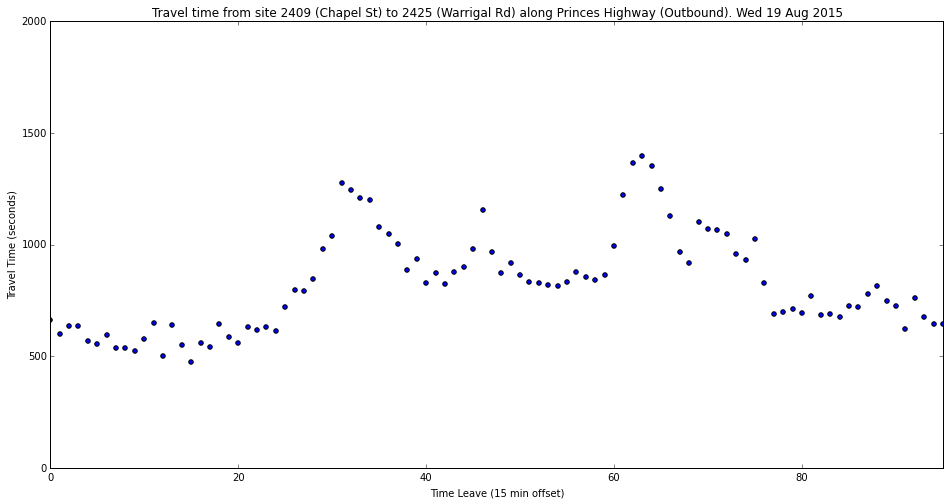

In [21]:
plt.figure(figsize=(16,8))
plt.scatter(np.arange(len(ts_resampled)), ts_resampled.values)
plt.title("Travel time from site 2409 (Chapel St) to 2425 (Warrigal Rd) along Princes Highway (Outbound). Wed 19 Aug 2015")
plt.ylabel("Travel Time (seconds)")
plt.xlabel("Time Leave (15 min offset)")
plt.xlim([0,95])
plt.ylim([0,2000])
plt.show()